In [1]:
import uproot
import numpy as np
import math
import torch
import torch_geometric
import random
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as func

In [2]:
#############################
# Normalisation values
#############################

# track shower score
trackShowerLimitLow = -1.0
trackShowerLimitHigh = 1.0
trackShowerInterval = math.fabs(trackShowerLimitLow) + math.fabs(trackShowerLimitHigh)

# nHits
nHitsLimitLow = 0
nHitsLimitHigh = 2000
nHitsInterval = math.fabs(nHitsLimitLow) + math.fabs(nHitsLimitHigh)

# charge
chargeLimitLow = 0
chargeLimitHigh = 1e6
chargeInterval = math.fabs(chargeLimitLow) + math.fabs(chargeLimitHigh)

# vertex x
vertexXLimitLow = -400
vertexXLimitHigh = 400
vertexXInterval = math.fabs(vertexXLimitLow) + math.fabs(vertexXLimitHigh)

# vertex y
vertexYLimitLow = -1400
vertexYLimitHigh = 1400
vertexYInterval = math.fabs(vertexYLimitLow) + math.fabs(vertexYLimitHigh)

# vertex z
vertexZLimitLow = -100
vertexZLimitHigh = 1500
vertexZInterval = math.fabs(vertexZLimitLow) + math.fabs(vertexZLimitHigh)

# showerDirX_vis
showerDirLimitLow = -1.1
showerDirLimitHigh = 1.1
showerDirInterval = math.fabs(showerDirLimitLow) + math.fabs(showerDirLimitHigh)

# ivysaurusMuon
ivysaurusLimitLow = -1.0
ivysaurusLimitHigh = 1.0
ivysaurusInterval = math.fabs(ivysaurusLimitLow) + math.fabs(ivysaurusLimitHigh)

# wiggliness
wigglinessLimitLow = -1.0
wigglinessLimitHigh = 60.0
wigglinessInterval = math.fabs(wigglinessLimitLow) + math.fabs(wigglinessLimitHigh)

# trackLength
trackLengthLimitLow = -100.0
trackLengthLimitHigh = 1000.0
trackLengthInterval = math.fabs(trackLengthLimitLow) + math.fabs(trackLengthLimitHigh)

# displacement
displacementLimitLow = -10.0
displacementLimitHigh = 100.0
displacementInterval = math.fabs(displacementLimitLow) + math.fabs(displacementLimitHigh)

# dca
dcaLimitLow = -10.0
dcaLimitHigh = 50.0  
dcaInterval = math.fabs(dcaLimitLow) + math.fabs(dcaLimitHigh)

In [3]:
#############################
# Some config
#############################

PLOT_DISTRIBUTIONS = True
MAX_GEN = 5 # We need to always be able to define the classes
BATCH_SIZE = 64
TRAIN_FRACTION = 0.8
N_EPOCH = 100
DO_NORMALISATION = True
#validation_fraction = 0.2 - used when training to update parameters
#test_fraction - used after training to check out performance

In [4]:
#######################################
# Helper Functions for visualization
#######################################
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

In [5]:
#############################
# Let's read the file
#############################

#fileName = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/nu_dune10kt_1x2x6_1413_762_20230826T183753Z_gen_g4_detsim_hitreco_ccnutree.root'
fileName = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree.root'

treeFile = uproot.open(fileName)
tree = treeFile['ccnuselection/ccnusel']
branches = tree.arrays()

In [6]:
#############################
# Get event-level stuff
#############################
run = np.array(branches['Run'])
subrun = np.array(branches['SubRun'])
event = np.array(branches['Event'])
    
#############################
# Get pfp-level stuff - these cannot be numpy arrays...
#############################
trackShowerScore_main = branches['RecoPFPTrackShowerScore']
nHits_main = branches['RecoPFPRecoNHits']
charge_main = branches['RecoPFPRecoCharge']
vertexX_main = branches['RecoPFPRecoVertexX']
vertexY_main = branches['RecoPFPRecoVertexY']
vertexZ_main = branches['RecoPFPRecoVertexZ']
showerDirX_main = branches['RecoShowerRecoDirX']  # not the best direction estimate, placeholder
showerDirY_main = branches['RecoShowerRecoDirY']
showerDirZ_main = branches['RecoShowerRecoDirZ']
ivysaurusMuon_main = branches['RecoPFPIvysaurusMuon']
ivysaurusProton_main = branches['RecoPFPIvysaurusProton']
ivysaurusPion_main = branches['RecoPFPIvysaurusPion']
ivysaurusElectron_main = branches['RecoPFPIvysaurusElectron']
ivysaurusPhoton_main = branches['RecoPFPIvysaurusPhoton']
wiggliness_main = branches['RecoTrackDeflecAngleSD']
trackLength_main = branches['RecoTrackLength']
displacement_main = branches['RecoShowerPandrizzleDisplacement']
dca_main = branches['RecoShowerPandrizzleDCA']

#############################
# Network truth - these cannot be numpy arrays...
#############################
trueVisibleGeneration_main = branches['RecoPFPTrueVisibleGeneration']

#############################
# How many entries are we working with?
#############################
nEntries = run.shape[0]
print('We are working with:', nEntries, 'entries')

We are working with: 23900 entries


In [7]:
#############################
# Let's create our graphs!
#############################

# thought - do we have to make sure there are no gaps in our indicies?

data_set = []

trackShowerScore_vis = []
nHits_vis = []
charge_vis = []
vertexX_vis = []
vertexY_vis = []
vertexZ_vis = []
showerDirX_vis = []
showerDirY_vis = []
showerDirZ_vis = []
ivysaurusMuon_vis = []
ivysaurusProton_vis = []
ivysaurusPion_vis = []
ivysaurusElectron_vis = []
ivysaurusPhoton_vis = []
wiggliness_vis = []
trackLength_vis = []
displacement_vis = []
dca_vis = []

for iEvent in range(nEntries) : #range(nEntries) :
    
    nPFPs = len(trueVisibleGeneration_main[iEvent])
    
    event_node_features = []
    event_node_class = []
    source_index = []
    target_index = []
    
    nGraphNodes = 0
    
    # Creating numpy arrays
    trackShowerScore_np = np.array(trackShowerScore_main[iEvent])
    nHits_np = np.array(nHits_main[iEvent])
    charge_np = np.array(charge_main[iEvent])
    vertexX_np = np.array(vertexX_main[iEvent])
    vertexY_np = np.array(vertexY_main[iEvent])
    vertexZ_np = np.array(vertexZ_main[iEvent])
    showerDirX_np = np.array(showerDirX_main[iEvent])
    showerDirY_np = np.array(showerDirY_main[iEvent])
    showerDirZ_np = np.array(showerDirZ_main[iEvent])
    ivysaurusMuon_np = np.array(ivysaurusMuon_main[iEvent])
    ivysaurusProton_np = np.array(ivysaurusProton_main[iEvent])
    ivysaurusPion_np = np.array(ivysaurusPion_main[iEvent])
    ivysaurusElectron_np = np.array(ivysaurusElectron_main[iEvent])
    ivysaurusPhoton_np = np.array(ivysaurusPhoton_main[iEvent])
    wiggliness_np = np.array(wiggliness_main[iEvent])
    trackLength_np = np.array(trackLength_main[iEvent])
    displacement_np = np.array(displacement_main[iEvent])
    dca_np = np.array(dca_main[iEvent])
        
    # Because i'm an idiot and set the vertex default value bad
    failedVertexMask = vertexX_np < -990.0
    vertexX_np[failedVertexMask] = -9999.0
    vertexY_np[failedVertexMask] = -9999.0
    vertexZ_np[failedVertexMask] = -9999.0
            
    # Normalise
    if (DO_NORMALISATION) :
        trackShowerScore_np[trackShowerScore_np < trackShowerLimitLow] = trackShowerLimitLow
        trackShowerScore_np[trackShowerScore_np > trackShowerLimitHigh] = trackShowerLimitHigh
        trackShowerScore_np = trackShowerScore_np / trackShowerInterval

        nHits_np[nHits_np < nHitsLimitLow] = nHitsLimitLow
        nHits_np[nHits_np > nHitsLimitHigh] = nHitsLimitHigh
        nHits_np = nHits_np / nHitsInterval

        charge_np[charge_np < chargeLimitLow] = chargeLimitLow
        charge_np[charge_np > chargeLimitHigh] = chargeLimitHigh
        charge_np = charge_np / chargeInterval

        vertexX_np[vertexX_np < vertexXLimitLow] = vertexXLimitLow
        vertexX_np[vertexX_np > vertexXLimitHigh] = vertexXLimitHigh
        vertexX_np = vertexX_np / vertexXInterval

        vertexY_np[vertexY_np < vertexYLimitLow] = vertexYLimitLow
        vertexY_np[vertexY_np > vertexYLimitHigh] = vertexYLimitHigh
        vertexY_np = vertexY_np / vertexYInterval

        vertexZ_np[vertexZ_np < vertexZLimitLow] = vertexZLimitLow
        vertexZ_np[vertexZ_np > vertexZLimitHigh] = vertexZLimitHigh
        vertexZ_np = vertexZ_np / vertexZInterval

        showerDirX_np[showerDirX_np < showerDirLimitLow] = showerDirLimitLow
        showerDirX_np[showerDirX_np > showerDirLimitHigh] = showerDirLimitHigh
        showerDirX_np = showerDirX_np / showerDirInterval

        showerDirY_np[showerDirY_np < showerDirLimitLow] = showerDirLimitLow
        showerDirY_np[showerDirY_np > showerDirLimitHigh] = showerDirLimitHigh
        showerDirY_np = showerDirY_np / showerDirInterval

        showerDirZ_np[showerDirZ_np < showerDirLimitLow] = showerDirLimitLow
        showerDirZ_np[showerDirZ_np > showerDirLimitHigh] = showerDirLimitHigh
        showerDirZ_np = showerDirZ_np / showerDirInterval

        ivysaurusMuon_np[ivysaurusMuon_np < ivysaurusLimitLow] = ivysaurusLimitLow
        ivysaurusMuon_np[ivysaurusMuon_np > ivysaurusLimitHigh] = ivysaurusLimitHigh
        ivysaurusMuon_np = ivysaurusMuon_np / ivysaurusInterval

        ivysaurusProton_np[ivysaurusProton_np < ivysaurusLimitLow] = ivysaurusLimitLow
        ivysaurusProton_np[ivysaurusProton_np > ivysaurusLimitHigh] = ivysaurusLimitHigh
        ivysaurusProton_np = ivysaurusProton_np / ivysaurusInterval

        ivysaurusPion_np[ivysaurusPion_np < ivysaurusLimitLow] = ivysaurusLimitLow
        ivysaurusPion_np[ivysaurusPion_np > ivysaurusLimitHigh] = ivysaurusLimitHigh
        ivysaurusPion_np = ivysaurusPion_np / ivysaurusInterval

        ivysaurusElectron_np[ivysaurusElectron_np < ivysaurusLimitLow] = ivysaurusLimitLow
        ivysaurusElectron_np[ivysaurusElectron_np > ivysaurusLimitHigh] = ivysaurusLimitHigh
        ivysaurusElectron_np = ivysaurusElectron_np / ivysaurusInterval

        ivysaurusPhoton_np[ivysaurusPhoton_np < ivysaurusLimitLow] = ivysaurusLimitLow
        ivysaurusPhoton_np[ivysaurusPhoton_np > ivysaurusLimitHigh] = ivysaurusLimitHigh
        ivysaurusPhoton_np = ivysaurusPhoton_np / ivysaurusInterval

        wiggliness_np[wiggliness_np < wigglinessLimitLow] = wigglinessLimitLow
        wiggliness_np[wiggliness_np > wigglinessLimitHigh] = wigglinessLimitHigh
        wiggliness_np = wiggliness_np / wigglinessInterval

        trackLength_np[trackLength_np < trackLengthLimitLow] = trackLengthLimitLow
        trackLength_np[trackLength_np > trackLengthLimitHigh] = trackLengthLimitHigh
        trackLength_np = trackLength_np / trackLengthInterval

        displacement_np[displacement_np < displacementLimitLow] = displacementLimitLow
        displacement_np[displacement_np > displacementLimitHigh] = displacementLimitHigh
        displacement_np = displacement_np / displacementInterval

        dca_np[dca_np < dcaLimitLow] = dcaLimitLow
        dca_np[dca_np > dcaLimitHigh] = dcaLimitHigh
        dca_np = dca_np / dcaInterval      
    
    for iSourceParticle in range(nPFPs) :
                
        # Truth
        trueGen_source = trueVisibleGeneration_main[iEvent][iSourceParticle]
        
        if (trueGen_source < 2) : 
            continue
                
        # Cap, and make sure it starts from zero... (0 == primary)
        trueGen_source = min(trueGen_source, MAX_GEN) - 2
        
        # Node features
        trackShowerScore = trackShowerScore_np[iSourceParticle]
        nHits = nHits_np[iSourceParticle]
        charge = charge_np[iSourceParticle]
        vertexX = vertexX_np[iSourceParticle]
        vertexY = vertexY_np[iSourceParticle]
        vertexZ = vertexZ_np[iSourceParticle]
        showerDirX = showerDirX_np[iSourceParticle]
        showerDirY = showerDirY_np[iSourceParticle]
        showerDirZ = showerDirZ_np[iSourceParticle]
        ivysaurusMuon = ivysaurusMuon_np[iSourceParticle]
        ivysaurusProton = ivysaurusProton_np[iSourceParticle]
        ivysaurusPion = ivysaurusPion_np[iSourceParticle]
        ivysaurusElectron = ivysaurusElectron_np[iSourceParticle]
        ivysaurusPhoton = ivysaurusPhoton_np[iSourceParticle]
        wiggliness = wiggliness_np[iSourceParticle]
        trackLength = trackLength_np[iSourceParticle]
        displacement = displacement_np[iSourceParticle]
        dca = dca_np[iSourceParticle]
    
        # For visualisation...
        if PLOT_DISTRIBUTIONS :
            trackShowerScore_vis.append(trackShowerScore)
            nHits_vis.append(nHits)
            charge_vis.append(charge)
            vertexX_vis.append(vertexX)
            vertexY_vis.append(vertexY)
            vertexZ_vis.append(vertexZ)
            showerDirX_vis.append(showerDirX)
            showerDirY_vis.append(showerDirY)
            showerDirZ_vis.append(showerDirZ)
            ivysaurusMuon_vis.append(ivysaurusMuon)
            ivysaurusProton_vis.append(ivysaurusProton)
            ivysaurusPion_vis.append(ivysaurusPion)
            ivysaurusElectron_vis.append(ivysaurusElectron)
            ivysaurusPhoton_vis.append(ivysaurusPhoton)
            wiggliness_vis.append(wiggliness)
            trackLength_vis.append(trackLength)
            displacement_vis.append(displacement)
            dca_vis.append(dca)
            
        # Create our node features
        thisModeFeatures = [trackShowerScore, nHits, charge, vertexX, vertexY, vertexZ, \
                              showerDirX, showerDirY, showerDirZ, ivysaurusMuon, ivysaurusProton, \
                              ivysaurusPion, ivysaurusElectron, ivysaurusPhoton, wiggliness, \
                              trackLength, displacement, dca]
        
        # Append our node
        nGraphNodes += 1
        event_node_class.append(trueGen_source)
        event_node_features.append(thisModeFeatures)

    # Create our edges
    for iSourceParticle in range(nGraphNodes) :
        
        for iTargetParticle in range(nGraphNodes) :
            
            if (iSourceParticle == iTargetParticle) :
                continue
                
            # Append our edges, so that they're undirected
            source_index.append(iSourceParticle)
            target_index.append(iTargetParticle)         

    if (nGraphNodes == 0) :
        continue
    
    event_node_class = torch.tensor(event_node_class, dtype=torch.long)
    event_node_features = torch.tensor(event_node_features, dtype=torch.float)
    event_edge_index = torch.tensor([source_index, target_index], dtype=torch.long)
    
    # turn into data and add
    data = Data(x=event_node_features, edge_index=event_edge_index.t().contiguous(), y=event_node_class)
    data_set.append(data)

In [8]:
print('event_node_class:', event_node_class)
print('event_node_features:', event_node_features)
print('event_edge_index:', event_edge_index)

event_node_class: tensor([0, 0, 0])
event_node_features: tensor([[ 2.2176e-01,  3.7300e-01,  1.6911e-01,  1.3487e-01,  2.1408e-01,
          8.1773e-01,  7.8239e-02, -4.1955e-01,  1.5641e-01,  3.7080e-06,
          3.6288e-07,  4.3922e-06,  3.1913e-01,  1.8086e-01,  3.0227e-02,
          2.7077e-01,  4.7989e-03,  1.5505e-02],
        [ 2.3032e-01,  1.7950e-01,  6.9143e-02,  1.2853e-01,  2.1408e-01,
          8.1155e-01, -1.5429e-01, -3.7123e-01, -2.1212e-01,  4.8576e-05,
          1.2456e-05,  1.7974e-04,  5.9147e-02,  4.4061e-01,  9.9368e-02,
          1.7115e-01,  1.0199e-01,  2.7118e-01],
        [ 2.3197e-01,  1.3300e-01,  9.6525e-02,  1.4214e-01,  2.0737e-01,
          8.2209e-01,  1.1836e-01, -4.0832e-01,  1.6086e-01,  1.2776e-07,
          5.1243e-07,  1.6783e-06,  2.7384e-02,  4.7261e-01,  1.5905e-01,
          1.0148e-01,  1.9370e-01,  7.0990e-01]])
event_edge_index: tensor([[0, 0, 1, 1, 2, 2],
        [1, 2, 0, 2, 0, 1]])


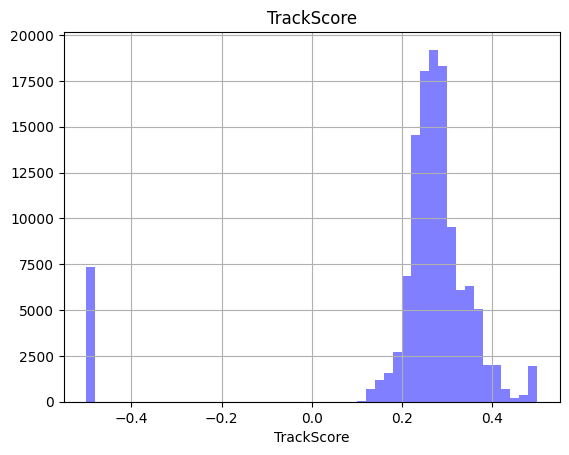

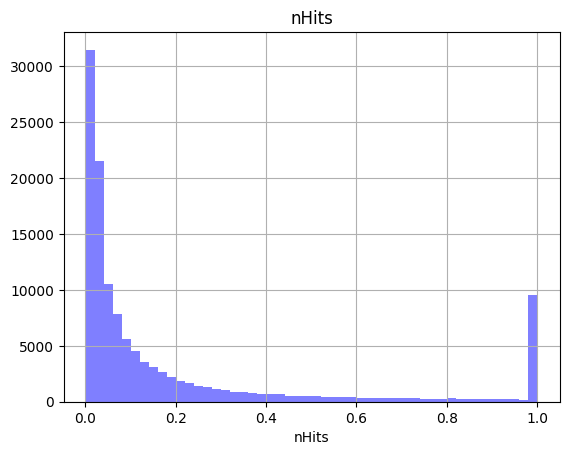

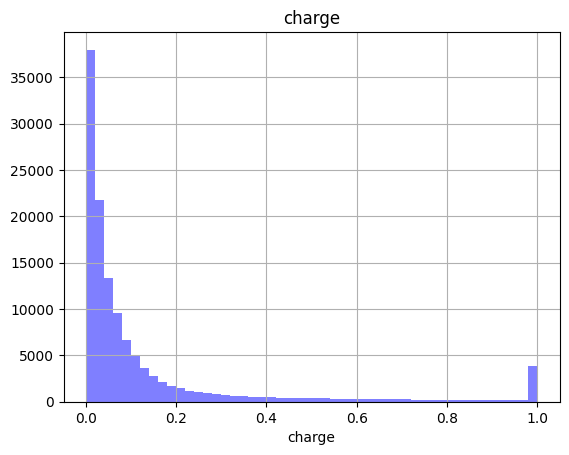

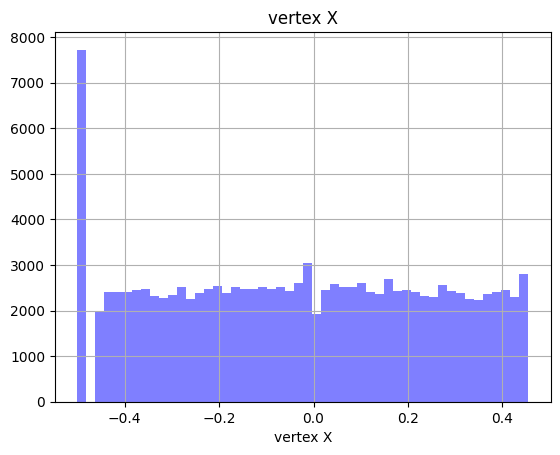

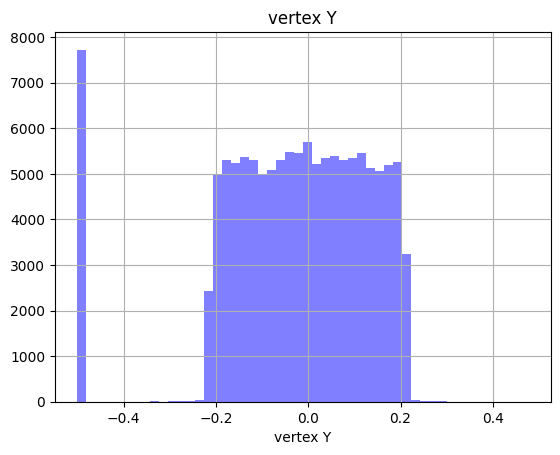

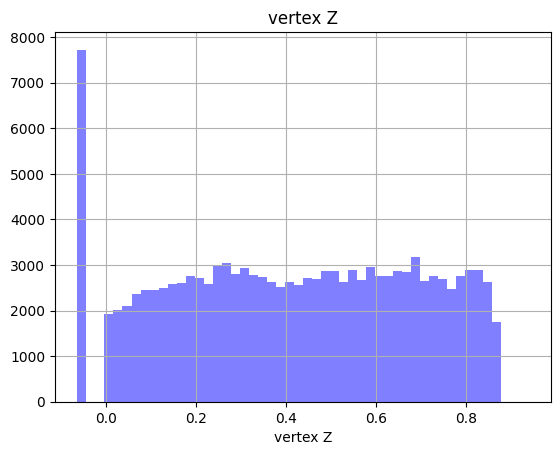

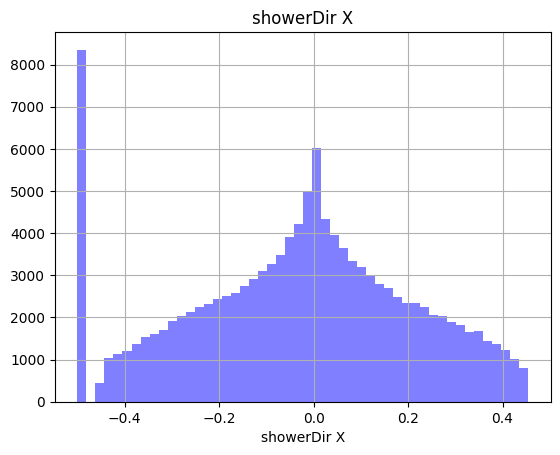

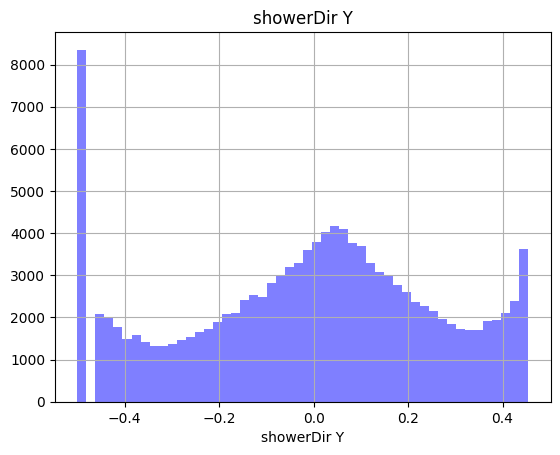

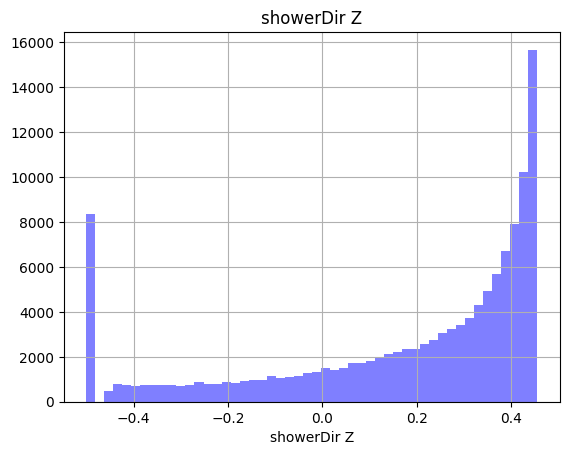

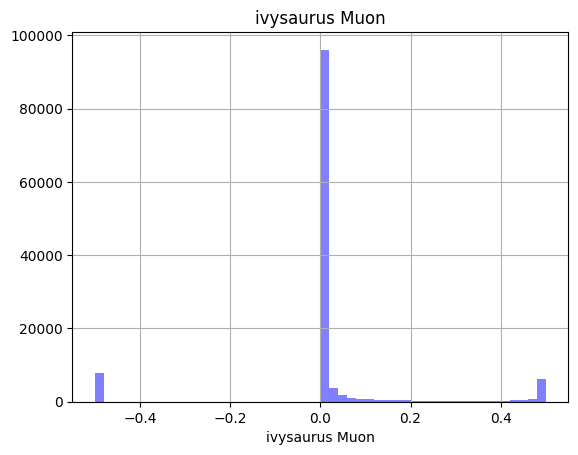

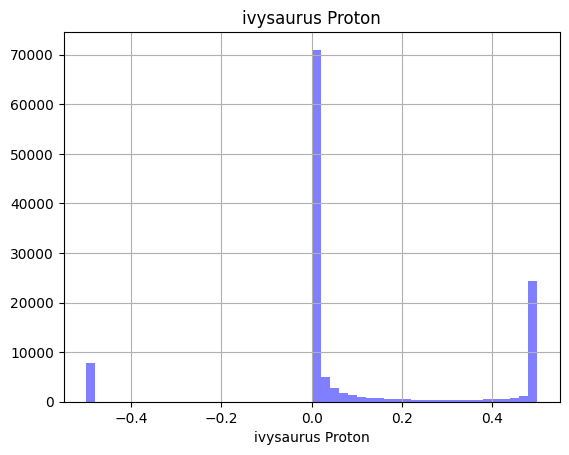

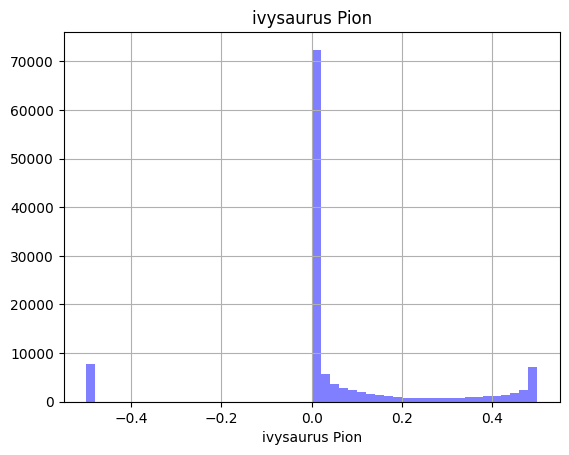

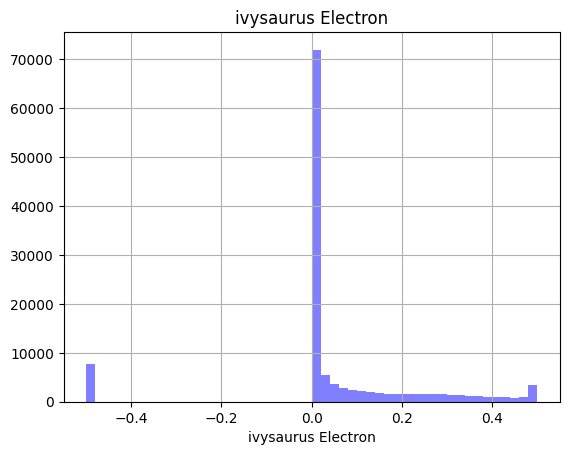

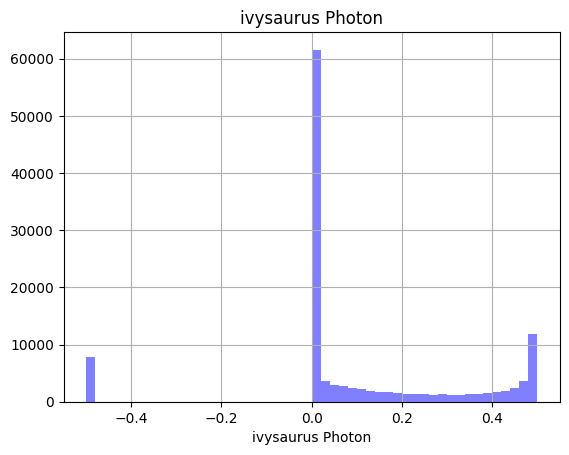

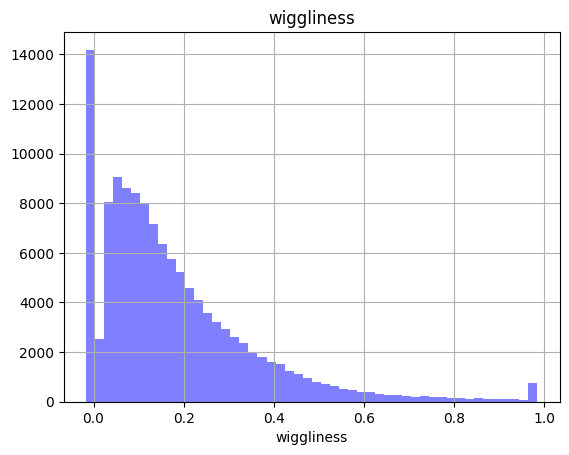

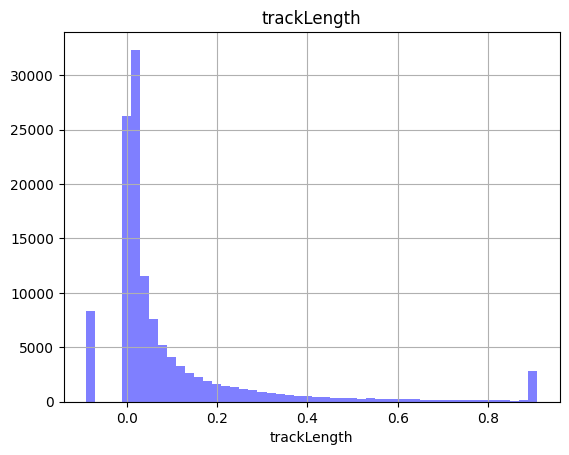

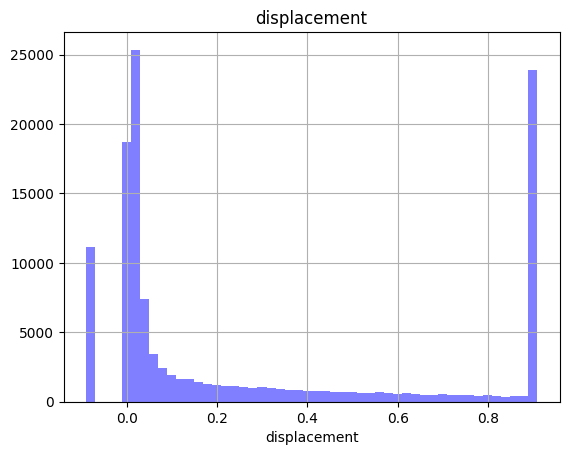

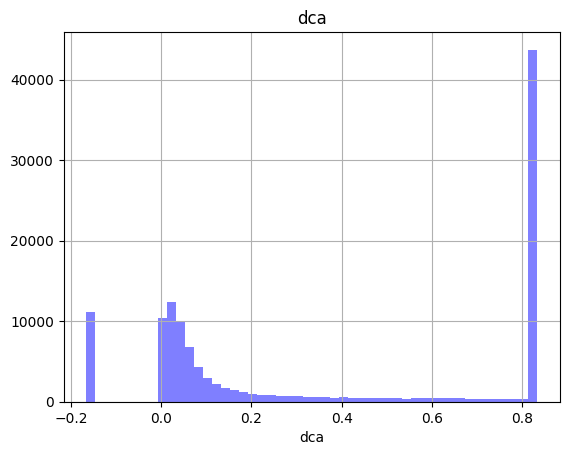

In [9]:
#############################
# Visualise node vars ...
#############################
if PLOT_DISTRIBUTIONS :
    
    plt.hist(trackShowerScore_vis, bins=50, alpha=0.5, color='blue')
    plt.title('TrackScore')
    plt.xlabel('TrackScore')
    plt.grid(True)
    plt.show()
    
    plt.hist(nHits_vis, bins=50, alpha=0.5, color='blue')
    plt.title('nHits')
    plt.xlabel('nHits')
    plt.grid(True)
    plt.show()
    
    plt.hist(charge_vis, bins=50, alpha=0.5, color='blue')
    plt.title('charge')
    plt.xlabel('charge')
    plt.grid(True)
    plt.show()
    
    plt.hist(vertexX_vis, bins=50, alpha=0.5, color='blue')
    plt.title('vertex X')
    plt.xlabel('vertex X')
    plt.grid(True)
    plt.show()

    plt.hist(vertexY_vis, bins=50, alpha=0.5, color='blue')
    plt.title('vertex Y')
    plt.xlabel('vertex Y')
    plt.grid(True)
    plt.show()
    
    plt.hist(vertexZ_vis, bins=50, alpha=0.5, color='blue')
    plt.title('vertex Z')
    plt.xlabel('vertex Z')
    plt.grid(True)
    plt.show()

    plt.hist(showerDirX_vis, bins=50, alpha=0.5, color='blue')
    plt.title('showerDir X')
    plt.xlabel('showerDir X')
    plt.grid(True)
    plt.show()
    
    plt.hist(showerDirY_vis, bins=50, alpha=0.5, color='blue')
    plt.title('showerDir Y')
    plt.xlabel('showerDir Y')
    plt.grid(True)
    plt.show()
    
    plt.hist(showerDirZ_vis, bins=50, alpha=0.5, color='blue')
    plt.title('showerDir Z')
    plt.xlabel('showerDir Z')
    plt.grid(True)
    plt.show()
    
    plt.hist(ivysaurusMuon_vis, bins=50, alpha=0.5, color='blue')
    plt.title('ivysaurus Muon')
    plt.xlabel('ivysaurus Muon')
    plt.grid(True)
    plt.show()
    
    plt.hist(ivysaurusProton_vis, bins=50, alpha=0.5, color='blue')
    plt.title('ivysaurus Proton')
    plt.xlabel('ivysaurus Proton')
    plt.grid(True)
    plt.show()
    
    plt.hist(ivysaurusPion_vis, bins=50, alpha=0.5, color='blue')
    plt.title('ivysaurus Pion')
    plt.xlabel('ivysaurus Pion')
    plt.grid(True)
    plt.show()
    
    plt.hist(ivysaurusElectron_vis, bins=50, alpha=0.5, color='blue')
    plt.title('ivysaurus Electron')
    plt.xlabel('ivysaurus Electron')
    plt.grid(True)
    plt.show()

    plt.hist(ivysaurusPhoton_vis, bins=50, alpha=0.5, color='blue')
    plt.title('ivysaurus Photon')
    plt.xlabel('ivysaurus Photon')
    plt.grid(True)
    plt.show()
    
    plt.hist(wiggliness_vis, bins=50, alpha=0.5, color='blue')
    plt.title('wiggliness')
    plt.xlabel('wiggliness')
    plt.grid(True)
    plt.show()
    
    plt.hist(trackLength_vis, bins=50, alpha=0.5, color='blue')
    plt.title('trackLength')
    plt.xlabel('trackLength')
    plt.grid(True)
    plt.show()
    
    plt.hist(displacement_vis, bins=50, alpha=0.5, color='blue')
    plt.title('displacement')
    plt.xlabel('displacement')
    plt.grid(True)
    plt.show()
    
    plt.hist(dca_vis, bins=50, alpha=0.5, color='blue')
    plt.title('dca')
    plt.xlabel('dca')
    plt.grid(True)
    plt.show()
    

In [10]:
print('================================================================================')
graphIndex = 0
print('We are working with:', len(data_set), 'graphs.')
#print('Number of features:', data_set.num_features)
#print('Number of classes: ', dataset_num_classes)   
print('Let\'s look at the', graphIndex, 'index graph...')
print('================================================================================')

print(f'Number of nodes: {data_set[graphIndex].num_nodes}')
print(f'Number of edges: {data_set[graphIndex].num_edges}')
print(data_set[graphIndex].edge_index)
print(f'Average node degree: {data_set[graphIndex].num_edges / data_set[graphIndex].num_nodes:.2f}')
#print(f'Number of training nodes: {data_set[graphIndex].train_mask.sum()}')
#print(f'Training node label rate: {int(data_set[graphIndex].train_mask.sum()) / data_set[graphIndex].num_nodes:.2f}')
print(f'Has isolated nodes: {data_set[graphIndex].has_isolated_nodes()}')
print(f'Has self-loops: {data_set[graphIndex].has_self_loops()}')
print(f'Is undirected: {data_set[graphIndex].is_undirected()}')

#G = to_networkx(data_set[graphIndex], to_undirected=True)
#visualize_graph(G, color=data_set[graphIndex].y)

We are working with: 23122 graphs.
Let's look at the 0 index graph...
Number of nodes: 3
Number of edges: 2
tensor([[0, 1],
        [0, 2],
        [1, 0],
        [1, 2],
        [2, 0],
        [2, 1]])
Average node degree: 0.67
Has isolated nodes: False
Has self-loops: True
Is undirected: False


ValueError: too many values to unpack (expected 2)

In [ ]:
###########################################
# Create training/testing nodes
###########################################

torch.manual_seed(12345)
data_set = random.sample(data_set, len(data_set))

train_size = int(len(data_set) * TRAIN_FRACTION)

data_set_train = data_set[:train_size]
data_set_test = data_set[train_size:]

print('================================================================================')
print(f'Number of training graphs: {len(data_set_train)}')
print(f'Number of test graphs: {len(data_set_test)}')
print('================================================================================')

In [ ]:
###########################################
# Let's create batches
###########################################
loader_train = DataLoader(data_set_train, batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(data_set_test, batch_size=BATCH_SIZE, shuffle=False)

print('================================================================================')
print('Let\' check our training batches')
print('================================================================================')

for step, data in enumerate(loader_train):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    
print('================================================================================')
print('Let\' check our testing batches')
print('================================================================================')

for step, data in enumerate(loader_test):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    

In [ ]:
#######################################
# Define our model
#######################################

NUM_FEATURES = 18
NUM_CLASSES = 4
HIDDEN_CHANNELS = 16

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = func.relu(x)
        #x = func.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

#######################################
# Create our model
#######################################
device = torch.device("cpu")
tangela = GCN(NUM_FEATURES, NUM_CLASSES, HIDDEN_CHANNELS).to(device)
print(tangela)

In [ ]:
#######################################
# Define training
#######################################
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimiser = torch.optim.Adam(tangela.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

#----------------------------------------------------------

def train(loader):
    
    tangela.train()
    
    #size = len(loader.dataset)
    #num_batches = len(loader)
    #print('TRAIN - size:', size)
    #print('TRAIN - num_batches:', num_batches)
    
    for batch, data in enumerate(loader):  # Iterate in batches over the training dataset.
        
        optimiser.zero_grad()                   # Clear gradients.
        out = tangela(data.x, data.edge_index)  # Perform a single forward pass.
        loss = criterion(out, data.y)           # Compute the loss.
        
        #print('data.y:', data.y)
        #print('out:', out)
        #print('data.edge_index:', data.edge_index)

        loss.backward()                         # Derive gradients.
        optimiser.step()                        # Update parameters based on gradients.
        

        
#----------------------------------------------------------
        
def test(loader):
    
    tangela.eval()
    
    correct = 0
    nSample = 0
    
    with torch.no_grad():
        for data in loader:                         # Iterate in batches over the training/test dataset.
            out = tangela(data.x, data.edge_index)  
            pred = out.argmax(dim=1)                # Use the class with highest probability.
            #print('-----------------------')
            #print('out:', out)
            #print('pred:', pred)
            #print('data.y', data.y)
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
            nSample += int(len(data.y))
        
    return float(correct) / float(nSample)            # Derive ratio of correct predictions.

#----------------------------------------------------------



In [ ]:
for epoch in range(N_EPOCH):
    train(loader_train)
    train_acc = test(loader_train)
    test_acc = test(loader_test)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')